Run the Database Connection File

In [18]:
%run ./db_connections.ipynb

Import the Necessary Packages and Libraries

In [2]:
import pymongo
import pandas as pd
import json
import matplotlib.pyplot as plt
from pymongo.errors import PyMongoError
from sqlalchemy import create_engine
import requests
import numpy as np
import psycopg2
import seaborn as sns
import sqlalchemy
from sqlalchemy import exc
from sqlalchemy import inspect

Load the Data from the json to the MongoDB Collection

In [3]:
# Function that checks if the MongoDB collection is empty, drops the collection if it is not empty, and loads the JSON data into the collection.
def check_and_load_json_data(json_file, collection):
    if collection.count_documents({}) > 0:
        collection.drop()
        print("Collection dropped successfully.")
    else:
        print("Collection is empty. Loading data from JSON file...")
    load_json_data(json_file, collection)
    print("Data loaded successfully from JSON file.")
    
# Function that loads the JSON data into the MongoDB collection.
def load_json_data(json_file, collection):
    try:
        with open(json_file) as f:
            data = json.load(f)
            collection.insert_many(data)
            print(f"Loaded {len(data)} records into MongoDB")
    except (FileNotFoundError, ValueError, PyMongoError) as e:
        print(f"Error occurred while loading JSON data into MongoDB: {e}")
        
# Connect to MongoDB
client, db, collection = connect_to_mongodb(mongoConnectionstring, mongoDatabasename, mongoCollectionnameFF)

# Call the check_and_load the JSON
check_and_load_json_data('Food_Service_Inspections.json', collection)

The connection has been established successfully
Collection dropped successfully.
Loaded 26544 records into MongoDB
Data loaded successfully from JSON file.


Load the Data from the MongoDB Collection to a Pandas Dataframe

In [4]:
def load_FoodInspectiondata_to_dataframe(collection):
    try:
        if collection.count_documents({}) > 0:
            # Retrieve data from MongoDB into a DataFrame
            FoodInspection_df = pd.DataFrame(list(collection.find()))
            print("Data loaded into a DataFrame.")
        else:
            print("No data available in MongoDB collection.")
            FoodInspection_df = None
    except Exception as e:
        print(f"Error occurred while loading data from MongoDB: {e}")
        FoodInspection_df = None
    return FoodInspection_df

FoodInspection_df = load_FoodInspectiondata_to_dataframe(collection)

Data loaded into a DataFrame.


In [5]:
FoodInspection_df.head()

,_id,UNID,NAME,STAGE,OPNDATE,CLSDATE,STATUS,TYPE,RANKING,PBUILD,...,EDATE,TIMEIN,TIMEOUT,TIMESP,COMM,INSPNO,CODE,REPEAT,CORRECTED,CriticalTier
0,6445cf3decb12938009c344d,0038583E5641B86585257C270066F583,DPR-Team Teen Program,Active,11/18/2013 12:00:00 AM,.,Permitted,Mobile Food Unit,Risk Category 1,,...,6/22/2017 12:00:00 AM,12/31/1899 11:00:00 AM,12/31/1899 11:45:00 AM,0.75,"Conditions: Snow cones, cotton candy and popco...",015C8B60B2FC4F0985258192004A29B7,,NO,,
1,6445cf3decb12938009c344e,0038583E5641B86585257C270066F583,DPR-Team Teen Program,Active,11/18/2013 12:00:00 AM,.,Permitted,Mobile Food Unit,Risk Category 1,,...,6/27/2016 12:00:00 AM,12/31/1899 1:15:00 PM,12/31/1899 2:00:00 PM,0.75,"Mobile hand washing sink unit, fill and empty ...",8A182BFD08BBF5C285257FDF0066A303,,NO,,
2,6445cf3decb12938009c344f,0038583E5641B86585257C270066F583,DPR-Team Teen Program,Active,11/18/2013 12:00:00 AM,.,Permitted,Mobile Food Unit,Risk Category 1,,...,6/26/2018 12:00:00 AM,12/31/1899 9:00:00 AM,12/31/1899 9:20:00 AM,0.3333,Decal #047 BOO: Arlington Mill Community Cente...,9A24150E3B9A5EF9852582B9005234C2,,NO,,
3,6445cf3decb12938009c3450,00500D38A7B20EF985257D77007137C6,Bowl'd(INACTIVE),Closed,10/20/2014 12:00:00 AM,8/1/2017 12:00:00 AM,Surrendered,Fast Food Restaurant,Risk Category 3,1028,...,3/29/2017 12:00:00 AM,12/31/1899 2:30:00 PM,12/31/1899 3:45:00 PM,1.25,,555C310A12DDD22C852580F2006A2A34,4-601.11,NO,,Core
4,6445cf3decb12938009c3451,00500D38A7B20EF985257D77007137C6,Bowl'd(INACTIVE),Closed,10/20/2014 12:00:00 AM,8/1/2017 12:00:00 AM,Surrendered,Fast Food Restaurant,Risk Category 3,1028,...,3/29/2017 12:00:00 AM,12/31/1899 2:30:00 PM,12/31/1899 3:45:00 PM,1.25,,555C310A12DDD22C852580F2006A2A34,"4-602.11(B,D,E)",NO,,Core


Data Cleaning and Pre-Processing

In [6]:
# Drop the columns that are not needed for the visualizations
def remove_columns(df, columns):
    return df.drop(columns, axis=1)
columns_to_drop = ['_id','STAGE', 'OPNDATE', 'CLSDATE', 'PDIR', 'PSTREET', 'PSTREETTYPE', 'PSTREETSUF', 'PSUITE', 'PCODE', 'ITYPE', 'TIMEIN', 'TIMEOUT', 'TIMESP', 'COMM', 'INSPNO', 'CODE', 'REPEAT', 'CORRECTED']
FoodInspection_df = remove_columns(FoodInspection_df, columns_to_drop)

# Replace empty cells with None
def replace_empty_strings_with_none(dataframe):
    return dataframe.replace('', None, inplace=True)
replace_empty_strings_with_none(FoodInspection_df)

# Remove missing values
def drop_rows_with_missing_values(dataframe):
    return dataframe.dropna(inplace=False)
FoodInspection_df = drop_rows_with_missing_values(FoodInspection_df)

# Remove duplicates 
def drop_duplicates(dataframe):     # drop duplicate rows
    dataframe = dataframe.drop_duplicates()
    dataframe = dataframe.loc[:,~dataframe.columns.duplicated()]     # drop duplicate columns    
    return dataframe
print('Number of rows before removing duplicates:', FoodInspection_df.shape[0])
print('Number of columns before removing duplicates:', FoodInspection_df.shape[1])
FoodInspection_df = drop_duplicates(FoodInspection_df) # remove duplicates using the drop_duplicates() function
print('Number of rows after removing duplicates:', FoodInspection_df.shape[0])
print('Number of columns after removing duplicates:', FoodInspection_df.shape[1])

# Count the number of duplicates in the dataset
def count_duplicate_rows(dataframe):
    return dataframe.duplicated().sum()
num_duplicates = count_duplicate_rows(FoodInspection_df)
print("Number of duplicates in the dataset: ", num_duplicates)

# Count the number of missing values in each column of the DataFrame
def count_missing_values(dataframe):
    num_missing = dataframe.isnull().sum()
    return num_missing.sum()
num_missing = count_missing_values(FoodInspection_df)
print(f"Total number of missing values: {num_missing}")

# Count the num of invalid values in the dataset
def count_invalid_values(dataframe):
    num_invalid_values = dataframe.isnull().sum().sum()
    return num_invalid_values
num_invalid_values = count_invalid_values(FoodInspection_df)
print("There are {} invalid values in the dataset.".format(num_invalid_values))

Number of rows before removing duplicates: 22466
Number of columns before removing duplicates: 10
Number of rows after removing duplicates: 10055
Number of columns after removing duplicates: 10
Number of duplicates in the dataset:  0
Total number of missing values: 0
There are 0 invalid values in the dataset.


In [7]:
# Rename column names for easy understanding of data
def rename_columns(df):
    column_map = {
        'UNID': 'identification',
        'NAME': 'name',
        'STATUS': 'status',
        'TYPE': 'type',
        'RANKING': 'ranking',
        'PBUILD': 'address',
        'PCITY': 'city',
        'PSTATE': 'state',
        'EDATE': 'date',
        'CriticalTier': 'critical'
    } 
    df.rename(columns=column_map, inplace=True) 
    return df
rename_columns(FoodInspection_df)

,identification,name,status,type,ranking,address,city,state,date,critical
3,00500D38A7B20EF985257D77007137C6,Bowl'd(INACTIVE),Surrendered,Fast Food Restaurant,Risk Category 3,1028,Arlington,VA,3/29/2017 12:00:00 AM,Core
7,00500D38A7B20EF985257D77007137C6,Bowl'd(INACTIVE),Surrendered,Fast Food Restaurant,Risk Category 3,1028,Arlington,VA,4/4/2016 12:00:00 AM,Core
11,00500D38A7B20EF985257D77007137C6,Bowl'd(INACTIVE),Surrendered,Fast Food Restaurant,Risk Category 3,1028,Arlington,VA,12/1/2016 12:00:00 AM,Priority
14,00754EF78961359F8525789D0052B055,Super Giant Bakery #0774,Permitted,Grocery Store Food Service,Risk Category 1,2515,Arlington,VA,4/18/2018 12:00:00 AM,Core
16,00754EF78961359F8525789D0052B055,Super Giant Bakery #0774,Permitted,Grocery Store Food Service,Risk Category 1,2515,Arlington,VA,4/18/2018 12:00:00 AM,Priority Foundation
...,...,...,...,...,...,...,...,...,...,...
26539,FFF57CF7B7A991D885256C25005D5C73,Subway Sandwiches & Salads,Permitted,Fast Food Restaurant,Risk Category 1,801,Arlington,VA,2/1/2018 12:00:00 AM,Priority
26540,FFF57CF7B7A991D885256C25005D5C73,Subway Sandwiches & Salads,Permitted,Fast Food Restaurant,Risk Category 1,801,Arlington,VA,2/6/2017 12:00:00 AM,Core
26541,FFF57CF7B7A991D885256C25005D5C73,Subway Sandwiches & Salads,Permitted,Fast Food Restaurant,Risk Category 1,801,Arlington,VA,2/6/2017 12:00:00 AM,Priority
26542,FFF57CF7B7A991D885256C25005D5C73,Subway Sandwiches & Salads,Permitted,Fast Food Restaurant,Risk Category 1,801,Arlington,VA,2/6/2017 12:00:00 AM,Priority Foundation


In [8]:
FoodInspection_df.head()

,identification,name,status,type,ranking,address,city,state,date,critical
3,00500D38A7B20EF985257D77007137C6,Bowl'd(INACTIVE),Surrendered,Fast Food Restaurant,Risk Category 3,1028,Arlington,VA,3/29/2017 12:00:00 AM,Core
7,00500D38A7B20EF985257D77007137C6,Bowl'd(INACTIVE),Surrendered,Fast Food Restaurant,Risk Category 3,1028,Arlington,VA,4/4/2016 12:00:00 AM,Core
11,00500D38A7B20EF985257D77007137C6,Bowl'd(INACTIVE),Surrendered,Fast Food Restaurant,Risk Category 3,1028,Arlington,VA,12/1/2016 12:00:00 AM,Priority
14,00754EF78961359F8525789D0052B055,Super Giant Bakery #0774,Permitted,Grocery Store Food Service,Risk Category 1,2515,Arlington,VA,4/18/2018 12:00:00 AM,Core
16,00754EF78961359F8525789D0052B055,Super Giant Bakery #0774,Permitted,Grocery Store Food Service,Risk Category 1,2515,Arlington,VA,4/18/2018 12:00:00 AM,Priority Foundation


In [9]:
print(FoodInspection_df)

                         identification                        name  \
3      00500D38A7B20EF985257D77007137C6            Bowl'd(INACTIVE)   
7      00500D38A7B20EF985257D77007137C6            Bowl'd(INACTIVE)   
11     00500D38A7B20EF985257D77007137C6            Bowl'd(INACTIVE)   
14     00754EF78961359F8525789D0052B055    Super Giant Bakery #0774   
16     00754EF78961359F8525789D0052B055    Super Giant Bakery #0774   
...                                 ...                         ...   
26539  FFF57CF7B7A991D885256C25005D5C73  Subway Sandwiches & Salads   
26540  FFF57CF7B7A991D885256C25005D5C73  Subway Sandwiches & Salads   
26541  FFF57CF7B7A991D885256C25005D5C73  Subway Sandwiches & Salads   
26542  FFF57CF7B7A991D885256C25005D5C73  Subway Sandwiches & Salads   
26543  FFF57CF7B7A991D885256C25005D5C73  Subway Sandwiches & Salads   

            status                        type          ranking address  \
3      Surrendered        Fast Food Restaurant  Risk Category 3    1028 

Write the cleaned DataFrame to a CSV file

In [10]:
FoodInspection_df.to_csv('cleaned_food_inspection_data.csv', index=False)

Loading the saved Csv file 

In [11]:
FoodInspectionCleaned = pd.read_csv("/Users/subas/cleaned_food_inspection_data.csv")

Table Creation and Data Loading into PostgreSQL

In [19]:
# Function to create a table in PostgreSQL database for FoodInpection data.

def create_foodInspection_table(conn, table_name):
    try:
        cur = conn.cursor() # Create a cursor object for executing SQL queries.
        # SQL query to create the table with column names and data types.
        cur.execute(f'''
            CREATE TABLE IF NOT EXISTS {table_name} (identification VARCHAR(255),
                name VARCHAR(255),
                status VARCHAR(255),
                type VARCHAR(255),
                ranking VARCHAR(255),
                address VARCHAR(255),
                city VARCHAR(255),
                state VARCHAR(255),
                date DATE,
                critical VARCHAR(255)
            )
        ''')
        conn.commit() # Commit the transaction.
        print("Table created successfully!")
    except psycopg2.Error as e:
        print("Error creating table:", e)
        conn.rollback() # Rollback the transaction in case of an error.
    finally:
        cur.close() # Close the cursor.
        
table_name = postgresFoodinspectiontablename
create_foodInspection_table(conn, table_name)

Table created successfully!


In [20]:
# Function to load data from a DataFrame to a PostgreSQL table.

def loadFoodinspection_data_to_postgresql(conn, df, table_name):
    try:
        engine = establish_postgres_connection(postgresUsername, postgresPassword, postgresHost, postgresPort, postgresDbname)
        inspector = inspect(engine)
        # Check if the table already contains data, if so, delete all the rows.
        if table_name in inspector.get_table_names():
            with conn.cursor() as cursor:
                cursor.execute(f"DELETE FROM {table_name}")
                conn.commit()  # Commit the DELETE statement
                #print(f"All rows deleted from table '{table_name}'.")
        FoodInspectionCleaned.to_sql(table_name, engine, if_exists='append', index=False)
        engine.dispose() # Dispose the engine after data is loaded.
        print("Data loaded to PostgreSQL successfully!")
    except exc.SQLAlchemyError as e:
        print("Error loading data to PostgreSQL:", e)
        
loadFoodinspection_data_to_postgresql(conn, FoodInspectionCleaned, table_name)

Data loaded to PostgreSQL successfully!


Extract the Pre-processed and Structured Data that was loaded into Postgres into a Pandas Dataframe

In [21]:
# Function to extract data from PostgreSQL table and load it into a DataFrame

def extract_foodinspection_data_from_postgresql(engine, table_name):
    try:
        
        # Define the query to extract data
        query = f'SELECT * FROM {table_name}'
        df = pd.read_sql(query, engine)
        print("Data loaded from PostgreSQL to DataFrame successfully!")
        return df
    except Exception as e:
        print("Error loading data from PostgreSQL to DataFrame:", e)

engine = establish_postgres_connection(postgresUsername, postgresPassword, postgresHost, postgresPort, postgresDbname)
FoodInspection_df = extract_foodinspection_data_from_postgresql(engine, table_name)

Data loaded from PostgreSQL to DataFrame successfully!


In [22]:
conn.close() #Close the connection

Visualization

1) Bar chart showing the number of inspections conducted for each establishment type.

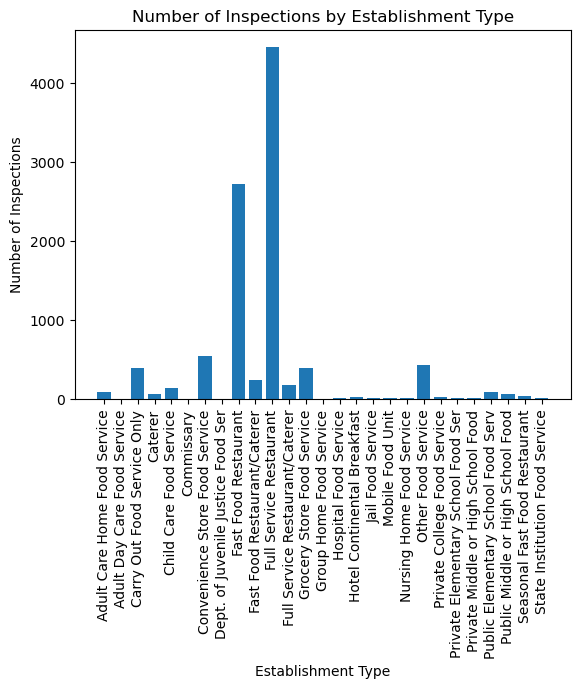

In [23]:
insp_by_type = FoodInspection_df.groupby('type')['identification'].count().reset_index()
insp_by_type = insp_by_type.rename(columns={'identification': 'Count'})
plt.bar(insp_by_type['type'], insp_by_type['Count'])
plt.xticks(rotation=90)
plt.xlabel('Establishment Type')
plt.ylabel('Number of Inspections')
plt.title('Number of Inspections by Establishment Type')
plt.show()

2) Horizontal bar chart showing the percentage of establishments with active, inactive, or other license statuses.

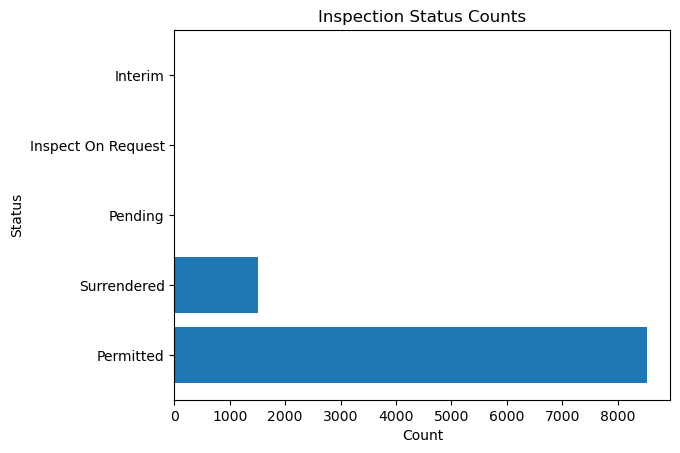

In [24]:
status_count = FoodInspection_df['status'].value_counts().reset_index()
status_count = status_count.rename(columns={'index': 'Status', 'status': 'Count'})
plt.barh(status_count['Status'], status_count['Count'])
plt.xlabel('Count')
plt.ylabel('Status')
plt.title('Inspection Status Counts')
plt.show()

3) Violation distribution by type and ranking.

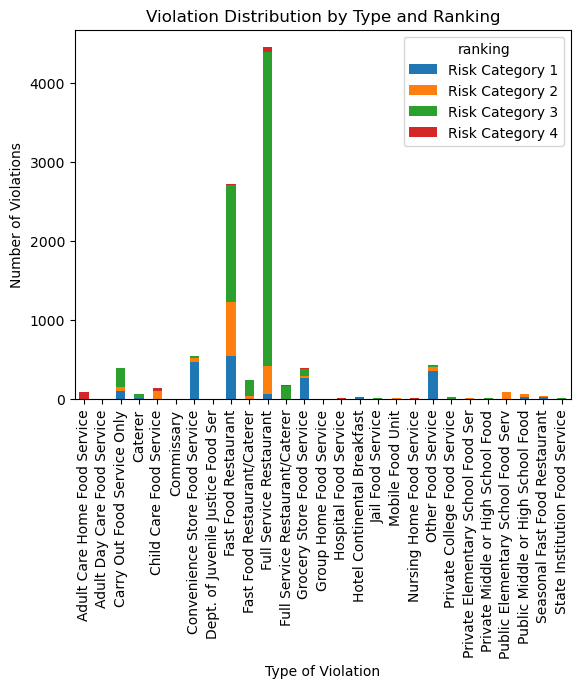

In [25]:
type_ranking_counts = FoodInspection_df.groupby(['type', 'ranking']).size().unstack(fill_value=0)
type_ranking_counts.plot(kind='bar', stacked=True)
plt.xlabel('Type of Violation')
plt.ylabel('Number of Violations')
plt.title('Violation Distribution by Type and Ranking')
plt.show()

4) Most common violations by type and ranking.

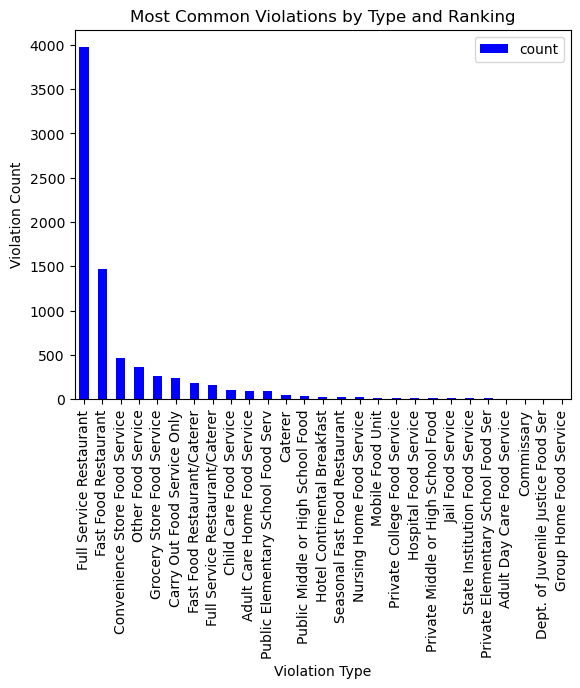

In [28]:
violation_counts = FoodInspection_df.groupby(['type', 'ranking']).size().reset_index(name='count')
most_common = violation_counts.sort_values('count', ascending=False).groupby('type').head(1)
most_common.plot(kind='bar', x='type', y='count', color='blue')
plt.title('Most Common Violations by Type and Ranking')
plt.xlabel('Violation Type')
plt.ylabel('Violation Count')
plt.show()